In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, PersistAD, LevelShiftAD, VolatilityShiftAD
from IPython.display import display
from ydata_profiling import ProfileReport
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
data_activity_dir = "../data/acf/df_activity_30m.txt"
data_temperature_dir = "../data/acf/t001_1h.txt"

df_activity_30m = pd.read_csv(
    data_activity_dir,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_t001_1h = pd.read_csv(
    data_temperature_dir,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_activity_30m["DateTime"] = pd.to_datetime(df_activity_30m["DateTime"], format="ISO8601")
df_t001_1h["DateTime_ISO8601"] = pd.to_datetime(df_t001_1h["DateTime_ISO8601"], format="ISO8601")

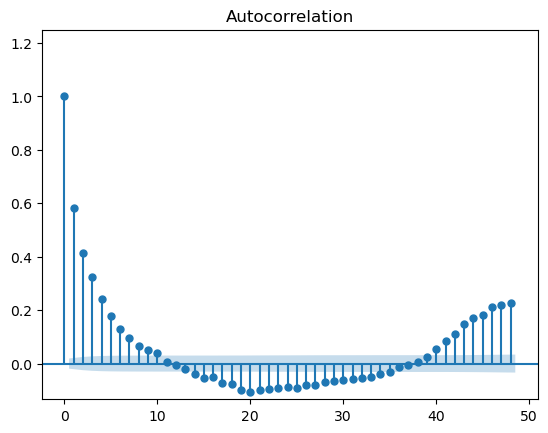

In [19]:
_ = plot_acf(df_activity_30m["Activity"], lags=48, auto_ylims=True)

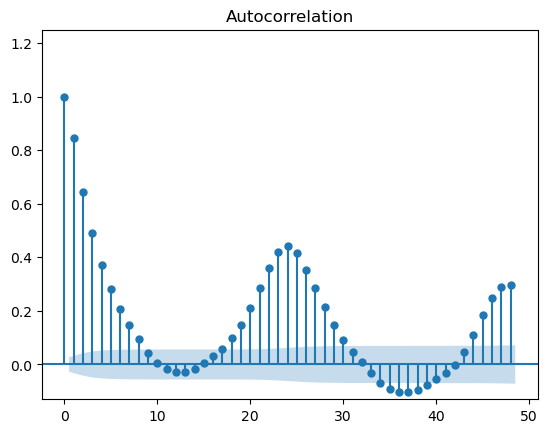

In [18]:
_ = plot_acf(df_t001_1h["Value_num"], lags=48, auto_ylims=True)

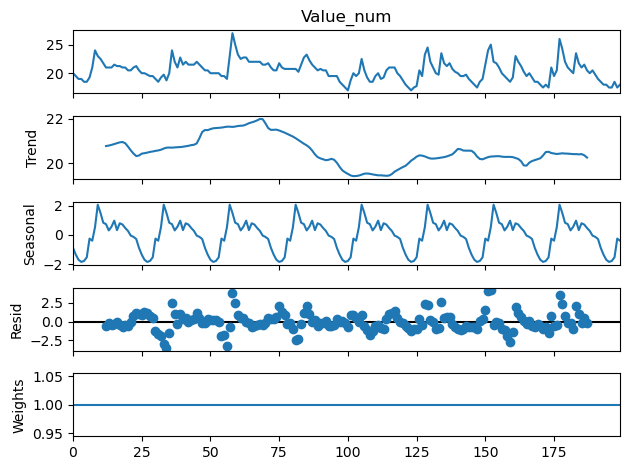

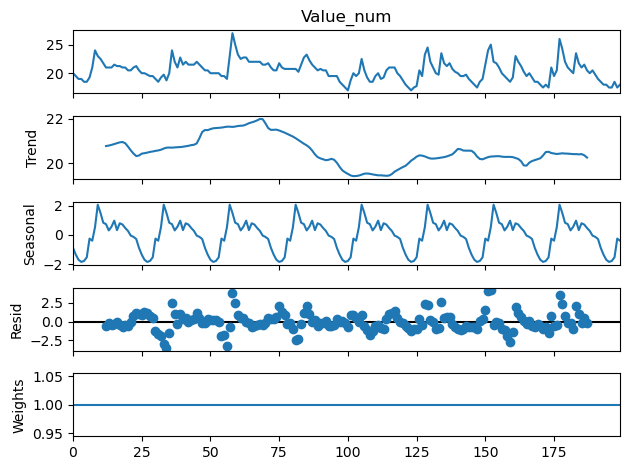

In [33]:
_ = seasonal_decompose(df_t001_1h["Value_num"][:200], model='additive', period=24)
_.plot(weights=True)
